# Data preprocessing for YOLO object detection

Prerequisites:
- numpy, matplotlib and pandas libraries are installed
- The original object detection dataset for traffic signs is in the same directory as this notebook

## Info:
This notebook only needs to be run __once__. It will transform the original dataset into the YOLO-format.
However there might be some additional preprocessing needed to the actual images to improve results. This will be done in a separate notebook

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

In [1]:
DATA_PATH = "FullIJCNN2013"
ppm_bb_params = ["x_min", "y_min", "x_max", "y_max"]
column_names = ["path"] + ppm_bb_params + ["class"]

In [ ]:
data = pd.read_csv(
    f"{DATA_PATH}/gt.txt",
    sep=";",
    names=column_names,
)
data

,path,x_min,y_min,x_max,y_max,class
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39
...,...,...,...,...,...,...
1208,00896.ppm,808,412,846,450,15
1209,00897.ppm,804,526,828,550,42
1210,00898.ppm,323,504,355,536,4
1211,00898.ppm,817,510,849,542,4


(800, 1360, 3)


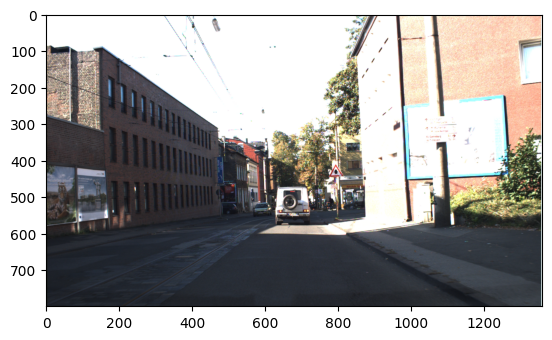

In [ ]:
from PIL import Image

img = Image.open(f"{DATA_PATH}/" + data["path"][0])
plt.imshow(img)
img = np.array(img)
print(img.shape)

## Rewrite bounding box format

In [5]:
def rewrite_coordinates(item):
    img = Image.open(f"{DATA_PATH}/" + data["path"][0])
    img = np.array(img)
    height, width, _ = img.shape
    centerx = (1 / width) * ((item["x_max"] + item["x_min"]) / 2)
    centery = (1 / height) * ((item["y_max"] + item["y_min"]) / 2)
    bb_width = (1 / width) * (item["x_max"] - item["x_min"])
    bb_height = (1 / height) * (item["y_max"] - item["y_min"])
    item[ppm_bb_params[0]] = centerx
    item[ppm_bb_params[1]] = centery
    item[ppm_bb_params[2]] = bb_width
    item[ppm_bb_params[3]] = bb_height
    return item

### Reduce to 4 classes

In [6]:
prohibitory = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]
danger = [11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
mandatory = [33, 34, 35, 36, 37, 38, 39, 40]
other = [6, 12, 13, 14, 17, 32, 41, 42]

data["Class_name"] = np.zeros(len(data))

for i, item in data.iterrows():
    data.at[i] = rewrite_coordinates(item)
    data["path"][i] = data["path"][i][:-4] + ".png"
    if data["class"][i] in prohibitory:
        data["class"][i] = 0
        data["Class_name"][i] = "prohibitory"
    elif data["class"][i] in danger:
        data["class"][i] = 1
        data["Class_name"][i] = "danger"
    elif data["class"][i] in mandatory:
        data["class"][i] = 2
        data["Class_name"][i] = "mandatory"
    elif data["class"][i] in other:
        data["class"][i] = 3
        data["Class_name"][i] = "other"
    else:
        data["class"][i] = -1

data.head()

,path,x_min,y_min,x_max,y_max,class,Class_name
0,00000.png,0.584191,0.535625,0.030147,0.04375,1,danger
1,00001.png,0.737868,0.512500,0.030147,0.05500,2,mandatory
2,00001.png,0.304412,0.653750,0.041176,0.07250,2,mandatory
3,00001.png,0.736765,0.453125,0.042647,0.06875,3,other
4,00002.png,0.697794,0.667500,0.083824,0.14500,2,mandatory


In [7]:
data["class"].value_counts()

0    557
3    274
1    219
2    163
Name: class, dtype: int64

In [8]:
bb_params = ["center_x", "center_y", "bb_width", "bb_height"]
rename_dict = dict(zip(ppm_bb_params, bb_params))
data = data.rename(columns=rename_dict)
data

,path,center_x,center_y,bb_width,bb_height,class,Class_name
0,00000.png,0.584191,0.535625,0.030147,0.04375,1,danger
1,00001.png,0.737868,0.512500,0.030147,0.05500,2,mandatory
2,00001.png,0.304412,0.653750,0.041176,0.07250,2,mandatory
3,00001.png,0.736765,0.453125,0.042647,0.06875,3,other
4,00002.png,0.697794,0.667500,0.083824,0.14500,2,mandatory
...,...,...,...,...,...,...,...
1208,00896.png,0.608088,0.538750,0.027941,0.04750,0,prohibitory
1209,00897.png,0.600000,0.672500,0.017647,0.03000,3,other
1210,00898.png,0.249265,0.650000,0.023529,0.04000,0,prohibitory
1211,00898.png,0.612500,0.657500,0.023529,0.04000,0,prohibitory


### Create png files from ppm files

In [ ]:
import glob
import os
import shutil

if not glob.glob(f"{DATA_PATH}/*.png"):
    for file in glob.glob(f"{DATA_PATH}/*.ppm"):
        img = Image.open(file)
        img.save(file[:-4] + ".png")

# Convert to YOLO format

The directory structure should look like this afterwards
### train
- images (folder including all training images)
- labels (folder including all training labels)

### test
- images (folder including all testing images)
- labels (folder including all testing labels)

### valid
- images (folder including all valid images)
- labels (folder including all valid labels)

data.yaml

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test, _, _ = train_test_split(
    data, data, test_size=0.2, random_state=42, stratify=data["class"]
)
df_train, df_val, _, _ = train_test_split(
    df_train, df_train, test_size=0.15, random_state=42, stratify=df_train["class"]
)

In [14]:
"""
- create directory "dataset_yolo"
- for each of the dataframes:
    - create a separate folder (train, test, val)
    - in that folder create two folders (images, labels)
    - copy the image into the images folder
    - create a txt file in the label folder with the same name as the image
        - contents of the file is the class + bb_coords separated by a whitespace
"""
YOLO_DATA_PATH = "dataset_yolo"
splits = ["train", "val", "test"]


def create_directories():
    if not os.path.exists(f"{YOLO_DATA_PATH}"):
        os.makedirs(YOLO_DATA_PATH)
    os.chdir(YOLO_DATA_PATH)
    for split in splits:
        if not os.path.exists(f"{split}"):
            os.makedirs(split)
            os.makedirs(f"{split}/images")
            os.makedirs(f"{split}/labels")
    os.chdir("../")


def copy_images_to_splits():
    for idx, df in enumerate([df_train, df_val, df_test]):
        df = df.reset_index(drop=True)
        for i in range(len(df)):
            current_img = f"{DATA_PATH}/{df['path'][i]}"
            shutil.copy(current_img, f"{YOLO_DATA_PATH}/{splits[idx]}/images")
            create_label_file(splits[idx], df.iloc[i])


def create_label_file(split_path, row):
    text_file_path = f"{YOLO_DATA_PATH}/{split_path}/labels/{row['path'][:-4]}.txt"
    string_to_write = f"{row['class']} {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(text_file_path, "w+") as f:
        f.write(string_to_write)

In [15]:
create_directories()

In [16]:
copy_images_to_splits()